In [17]:
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

MODEL_NAME = "distilbert-base-uncased"
print(f"Using model: {MODEL_NAME}")

Using model: distilbert-base-uncased


In [18]:
# Load your labeled data
train_df = pd.read_csv("manual_label_batch1_updated.csv")

TEXT_COL = "text"
LABEL_COL = "label"

In [19]:
from sklearn.utils.class_weight import compute_class_weight

# Check label distribution BEFORE training
print("\n" + "="*50)
print("LABEL DISTRIBUTION IN TRAINING DATA:")
print("="*50)
print(train_df[LABEL_COL].value_counts())
print(f"Class 0: {(train_df[LABEL_COL]==0).sum()} samples")
print(f"Class 1: {(train_df[LABEL_COL]==1).sum()} samples")
print()

# Ensure label is integer
train_df[LABEL_COL] = train_df[LABEL_COL].astype(int)

num_labels = train_df[LABEL_COL].nunique()
print(f"Number of unique labels: {num_labels}")

# ============================================================
# COMPUTE CLASS WEIGHTS to handle imbalance
# ============================================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_df[LABEL_COL].values
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print("\n" + "="*50)
print("CLASS WEIGHTS (to handle imbalance):")
print("="*50)
print(f"Class 0 weight: {class_weights[0]:.4f}")
print(f"Class 1 weight: {class_weights[1]:.4f}")
print("(Higher weight = model penalized more for getting it wrong)")
print()



LABEL DISTRIBUTION IN TRAINING DATA:
label
0    139
1     49
Name: count, dtype: int64
Class 0: 139 samples
Class 1: 49 samples

Number of unique labels: 2

CLASS WEIGHTS (to handle imbalance):
Class 0 weight: 0.6763
Class 1 weight: 1.9184
(Higher weight = model penalized more for getting it wrong)



In [20]:
# Create dataset
train_ds = Dataset.from_pandas(train_df[[TEXT_COL, LABEL_COL]])

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print("Tokenizing datasets...")

def tokenize_train(batch):
    enc = tokenizer(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)
    enc["labels"] = batch[LABEL_COL]
    return enc

train_ds = train_ds.map(tokenize_train, batched=True)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Tokenizing datasets...


Map:   0%|          | 0/188 [00:00<?, ? examples/s]

In [21]:
# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [22]:
# CUSTOM TRAINER WITH WEIGHTED LOSS
# ============================================================
class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Use weighted cross-entropy loss
        loss_fct = torch.nn.CrossEntropyLoss(
            weight=self.class_weights.to(model.device)
        )
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [23]:
# Training arguments with class weights if imbalanced
args = TrainingArguments(
    output_dir="distilbert_out",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",  # Save checkpoints
    report_to="none"
)

# Use the weighted trainer
trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    class_weights=class_weights_tensor
)

print("\n" + "="*50)
print("TRAINING MODEL...")
print("="*50)
trainer.train()



TRAINING MODEL...


Step,Training Loss


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=36, training_loss=0.652470588684082, metrics={'train_runtime': 60.2662, 'train_samples_per_second': 9.358, 'train_steps_per_second': 0.597, 'total_flos': 37355806420992.0, 'train_loss': 0.652470588684082, 'epoch': 3.0})

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# VALIDATION: Predict on the SAME data you trained on
# ============================================================
print("\n" + "="*50)
print("VALIDATING ON TRAINING DATA")
print("="*50)

pred = trainer.predict(train_ds)
logits = pred.predictions
y_hat = np.argmax(logits, axis=1)

# Get probabilities
probs = torch.softmax(torch.tensor(logits), dim=1).numpy()
conf = probs.max(axis=1)

# Get true labels
y_true = train_df[LABEL_COL].values

print("\n" + "="*50)
print("PREDICTION RESULTS:")
print("="*50)
print(f"Predicted class 0: {(y_hat==0).sum()} samples")
print(f"Predicted class 1: {(y_hat==1).sum()} samples")
print()

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_hat))
print()

print("Classification Report:")
print(classification_report(y_true, y_hat))



VALIDATING ON TRAINING DATA



PREDICTION RESULTS:
Predicted class 0: 108 samples
Predicted class 1: 80 samples

Confusion Matrix:
[[100  39]
 [  8  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       139
           1       0.51      0.84      0.64        49

    accuracy                           0.75       188
   macro avg       0.72      0.78      0.72       188
weighted avg       0.82      0.75      0.76       188



In [25]:
# Check some examples
print("\n" + "="*50)
print("SAMPLE PREDICTIONS (first 10):")
print("="*50)
comparison_df = train_df[[TEXT_COL, LABEL_COL]].copy()
comparison_df["pred_label"] = y_hat
comparison_df["confidence"] = conf
comparison_df["correct"] = comparison_df[LABEL_COL] == comparison_df["pred_label"]

print(comparison_df.head(10))

# Save results
comparison_df.to_csv("validation_results.csv", index=False)
print("\n Saved: validation_results.csv")

# Calculate accuracy
accuracy = (y_true == y_hat).mean()
print(f"\n{'='*50}")
print(f"OVERALL ACCURACY: {accuracy:.2%}")
print(f"{'='*50}")



SAMPLE PREDICTIONS (first 10):
                                                text  label  pred_label  \
0  Burn out among Cybersecurity leaders at a frus...      1           1   
1  Invitation to Participate in Research Study on...      0           1   
2  Dealing with feeling stuck in the security fie...      0           1   
3  How are you doing guys?\nIs this cybersecurity...      1           0   
4  Hey folks, for those of you working right now,...      0           0   
5  How did you overcome burnout?\nSo I've been in...      1           1   
6  Teams outage due to “networking issue” making ...      0           0   
7  How do you find the time?\nSince I've seen tha...      1           1   
8  Challenges in Tabletop exercises?\nWe run regu...      0           1   
9  Facebook, Instagram, WhatsApp hit by massive w...      0           0   

   confidence  correct  
0    0.516363     True  
1    0.522709    False  
2    0.549422    False  
3    0.562548    False  
4    0.560078    

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [27]:
def plot_confusion_matrix_basic(y_true, y_pred, class_names=['Not Burnout (0)', 'Burnout (1)']):
    """
    Basic confusion matrix with raw counts
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.title('Confusion Matrix - Raw Counts', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Add metrics as text
    accuracy = (y_true == y_pred).mean()
    plt.text(0.5, -0.15, f'Overall Accuracy: {accuracy:.2%}',
             ha='center', transform=plt.gca().transAxes, fontsize=12)

    plt.tight_layout()
    return plt

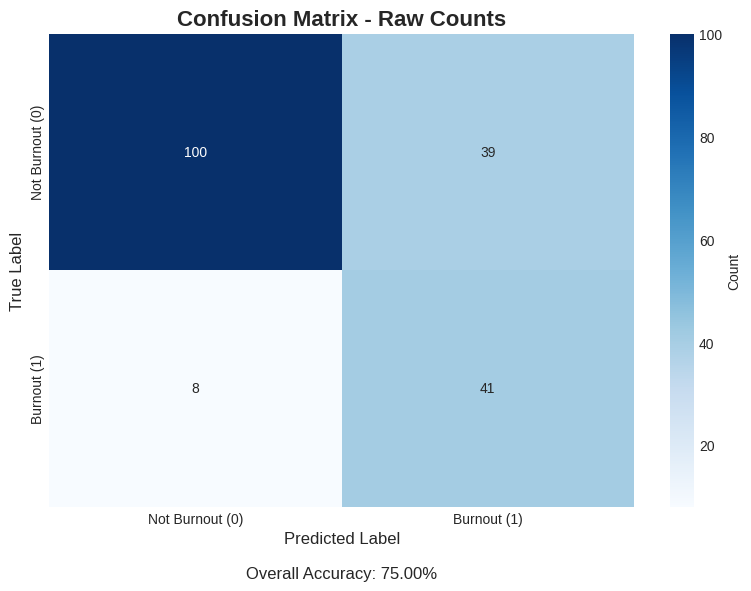

In [28]:
plot_confusion_matrix_basic(y_true, y_hat)
plt.savefig('confusion_matrix_basic.png', dpi=300, bbox_inches='tight')
plt.show()